In [1]:
import copy

from rmgpy.molecule.converter import to_rdkit_mol
from rmgpy.molecule.molecule import *
from rmgpy.species import Species
from rdkit import Chem
from rdkit.Chem.rdchem import ChiralType
from rdkit.Chem import AllChem
from typing import List, Tuple, Union

from arc.species import ARCSpecies
from arc.reaction import ARCReaction
from arc.species.converter import (check_isomorphism,
                                   molecules_from_xyz,
                                   str_to_xyz,
                                   xyz_to_str,
                                   xyz_to_x_y_z,
                                   xyz_to_xyz_file_format,
                                   xyz_to_dmat,
                                   xyz_to_coords_list,
                                  )
from IPython.display import display
import arc
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [2]:
import torch
import torch_geometric as tg
from torch_geometric.data import DataLoader

### Create some test reactions

### Create reactant

In [3]:
reactant = ARCSpecies(label='reactant', smiles='C[C][N]O[N][N]', multiplicity=1, charge=0)
# assume that ARC has already found the optimal geometry via QM calculation
reactant.final_xyz = str_to_xyz("""C  -1.3087    0.0068    0.0318
C  0.1715   -0.0344    0.0210
N  0.9054   -0.9001    0.6395
O  2.1683   -0.5483    0.3437
N  2.1499    0.5449   -0.4631
N  0.9613    0.8655   -0.6660
H  -1.6558    0.9505    0.4530
H  -1.6934   -0.0680   -0.9854
H  -1.6986   -0.8169    0.6255""")

reactant

In [4]:
print(xyz_to_xyz_file_format(reactant.final_xyz))

9

C      -1.30870000    0.00680000    0.03180000
C       0.17150000   -0.03440000    0.02100000
N       0.90540000   -0.90010000    0.63950000
O       2.16830000   -0.54830000    0.34370000
N       2.14990000    0.54490000   -0.46310000
N       0.96130000    0.86550000   -0.66600000
H      -1.65580000    0.95050000    0.45300000
H      -1.69340000   -0.06800000   -0.98540000
H      -1.69860000   -0.81690000    0.62550000



In [5]:
# same order as xyz above
reactant.mol.atoms

[<Atom 'C'>,
 <Atom 'C..'>,
 <Atom 'N.'>,
 <Atom 'O'>,
 <Atom 'N.'>,
 <Atom 'N..'>,
 <Atom 'H'>,
 <Atom 'H'>,
 <Atom 'H'>]

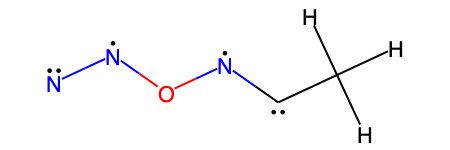

In [6]:
# convert the RMG Molecule object to an rdkit object
rdkit_reactant = to_rdkit_mol(reactant.mol, remove_h=False, return_mapping=False, sanitize=True)
rdkit_reactant

In [7]:
# different order as xyz above because RMG-Py's to_rdkit_mol sorts the atoms
[rdkit_reactant.GetAtomWithIdx(i).GetSymbol() for i in range(rdkit_reactant.GetNumAtoms())]

['O', 'N', 'N', 'N', 'C', 'C', 'H', 'H', 'H']

In [8]:
# must create conformers for rdkit to get 3D distance matrix
print(rdkit_reactant.GetNumConformers())
print(AllChem.EmbedMolecule(rdkit_reactant, maxAttempts=5))
print(rdkit_reactant.GetNumConformers())

0
0
1


In [9]:
# conformer does not change order
[rdkit_reactant.GetAtomWithIdx(i).GetSymbol() for i in range(rdkit_reactant.GetNumAtoms())]

['O', 'N', 'N', 'N', 'C', 'C', 'H', 'H', 'H']

### Create product

In [10]:
product = ARCSpecies(label='product', smiles='[N-]=[N+]=C(N=O)C', multiplicity=1, charge=0)
# accepts an ARC xyz dictionary
product.final_xyz = str_to_xyz("""C  -1.0108   -0.0114   -0.0610  
C  0.4780    0.0191    0.0139    
N  1.2974   -0.9930    0.4693    
O  0.6928   -1.9845    0.8337    
N  1.7456    1.9701   -0.6976    
N  1.1642    1.0763   -0.3716    
H  -1.4020    0.9134   -0.4821  
H  -1.3327   -0.8499   -0.6803   
H  -1.4329   -0.1554    0.9349""")

In [11]:
print(xyz_to_xyz_file_format(product.final_xyz))

9

C      -1.01080000   -0.01140000   -0.06100000
C       0.47800000    0.01910000    0.01390000
N       1.29740000   -0.99300000    0.46930000
O       0.69280000   -1.98450000    0.83370000
N       1.74560000    1.97010000   -0.69760000
N       1.16420000    1.07630000   -0.37160000
H      -1.40200000    0.91340000   -0.48210000
H      -1.33270000   -0.84990000   -0.68030000
H      -1.43290000   -0.15540000    0.93490000



In [12]:
# different order than xyz..maybe related to smiles string
product.mol.atoms

[<Atom 'N-'>,
 <Atom 'N+'>,
 <Atom 'C'>,
 <Atom 'N'>,
 <Atom 'O'>,
 <Atom 'C'>,
 <Atom 'H'>,
 <Atom 'H'>,
 <Atom 'H'>]

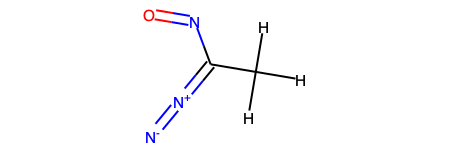

In [13]:
rdkit_product = to_rdkit_mol(product.mol, remove_h=False, return_mapping=False, sanitize=True)
rdkit_product

In [14]:
# different order than xyz but same order as 
[rdkit_product.GetAtomWithIdx(i).GetSymbol() for i in range(rdkit_reactant.GetNumAtoms())]

['O', 'N', 'N', 'N', 'C', 'C', 'H', 'H', 'H']

In [15]:
# must create conformers for rdkit to get 3D distance matrix
print(rdkit_product.GetNumConformers())
print(AllChem.EmbedMolecule(rdkit_product, maxAttempts=10))
print(rdkit_product.GetNumConformers())

0
0
1


In [16]:
# same order as xyz above
[rdkit_product.GetAtomWithIdx(i).GetSymbol() for i in range(rdkit_reactant.GetNumAtoms())]

['O', 'N', 'N', 'N', 'C', 'C', 'H', 'H', 'H']

### Use this reactant and product to create some replicate test reactions

In [17]:
rxn = ARCReaction(label='reactant <=> product')

In [18]:
rxn.r_species = [reactant]
rxn.p_species = [product]

In [19]:
arc_reactions = [rxn]*20

### generate features
- put this in `ts_gen_v2` as a function that can be imported by ARC
- **or put this as a method in the `gnn_isomerization` TS adapter in ARC**

In [20]:
from arc.common import arc_path
import os
import yaml

import sys
# define path to ts_gen_v2, which should be at the same level as ARC directory
ts_gen_v2_path = os.path.join(os.path.dirname(arc_path), 'ts_gen_v2')
sys.path.append(ts_gen_v2_path)

from features.featurization import atom_features

def ARC_featurization(arc_reaction):
    """
    This function creates features for the atom nodes and bond edges for one ARCReaction object.
    ARC obtains optimized geometries for the reactants and products in an isomerization reaction.
     
    Args:
        arc_reaction (ARCReaction): One instance of an ARCReaction.
    
    Returns:
        data (tg.data.Data()): PyTorch Geometric data objects.
        ts_xyz_dict (dict): Standard ARC xyz dictionary. 
                            The value for the'coords' key will is empty and will be replaced with the TS guess from the GNN.
    """
    
    # isomerization reactions have only 1 reactant and 1 product
    reactant = reaction.r_species[0]
    product = reaction.p_species[0]
    
#     # could get info from ARC, like distance matrix and number atoms. harder to get bond order or aromaticity..
#     D_r = xyz_to_dmat(reactant.get_xyz())
#     D_p = xyz_to_dmat(product.get_xyz())
#     n_atoms = len(reactant.mol.atoms)  # number of atoms
  
    rdkit_reactant = to_rdkit_mol(reactant.mol, remove_h=False, return_mapping=False, sanitize=True)
    rdkit_product = to_rdkit_mol(product.mol, remove_h=False, return_mapping=False, sanitize=True)
    # must embed before generating 3D distance matrix
    AllChem.EmbedMolecule(rdkit_reactant, maxAttempts=10)
    AllChem.EmbedMolecule(rdkit_product, maxAttempts=10)
    D_r = Chem.Get3DDistanceMatrix(rdkit_reactant)
    D_p = Chem.Get3DDistanceMatrix(rdkit_product)
    
    f_atoms = []      # atom (node) features
    f_bonds = []      # bond (edge) features
    edge_index = []   # list of tuples indicating presence of bonds
    n_atoms = rdkit_reactant.GetNumAtoms()
    
    for a1 in range(n_atoms):
        # Node features
        f_atoms.append(atom_features(rdkit_reactant.GetAtomWithIdx(a1)))

        # Edge features
        for a2 in range(a1 + 1, n_atoms):
            # fully connected graph
            edge_index.extend([(a1, a2), (a2, a1)])

            # for now, naively include both reac and prod
            b1_feats = [D_r[a1][a2], D_p[a1][a2]]
            b2_feats = [D_r[a2][a1], D_p[a2][a1]]

            # r_bond = r_mol.GetBondBetweenAtoms(a1, a2)
            # b1_feats.extend(bond_features(r_bond))
            # b2_feats.extend(bond_features(r_bond))
            #
            # p_bond = p_mol.GetBondBetweenAtoms(a1, a2)
            # b1_feats.extend(bond_features(p_bond))
            # b2_feats.extend(bond_features(p_bond))

            f_bonds.append(b1_feats)
            f_bonds.append(b2_feats)
        
    # assemble the features into a graph
    data = tg.data.Data()
    data.x = torch.tensor(f_atoms, dtype=torch.float)
    data.edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    data.edge_attr = torch.tensor(f_bonds, dtype=torch.float)

    ts_xyz_dict = copy.deepcopy(reactant.get_xyz())
    ts_xyz_dict['coords'] = None
    return data, ts_xyz_dict

In [21]:
reactant.get_xyz()

{'symbols': ('C', 'C', 'N', 'O', 'N', 'N', 'H', 'H', 'H'),
 'isotopes': (12, 12, 14, 16, 14, 14, 1, 1, 1),
 'coords': ((-1.3087, 0.0068, 0.0318),
  (0.1715, -0.0344, 0.021),
  (0.9054, -0.9001, 0.6395),
  (2.1683, -0.5483, 0.3437),
  (2.1499, 0.5449, -0.4631),
  (0.9613, 0.8655, -0.666),
  (-1.6558, 0.9505, 0.453),
  (-1.6934, -0.068, -0.9854),
  (-1.6986, -0.8169, 0.6255))}

### generate TS guess

In [22]:
from model.G2C import G2C

In [23]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Set paths to the optimal model weights. Note that these weights are for a model trained only on the training set
- we should retrain on the entire dataset with the optimal hyperparameters 
- we should retrain using the more advanced featurizaiton

In [24]:
# Set paths to the optimal model weights. 
# fix the typo in the name: paramAters to paramEters
yaml_file_name = os.path.join(ts_gen_v2_path, 'best_model', 'model_paramaters.yml')
state_dict = os.path.join(ts_gen_v2_path, 'best_model', 'epoch_95_state_dict')

In [25]:
# create the network with the best architecture from hyperopt and load the corresponding best weights
with open(yaml_file_name, 'r') as f:
    content = yaml.load(stream=f, Loader=yaml.FullLoader)
print(content)

model = G2C(**content).to(device)
model.load_state_dict(torch.load(state_dict, map_location=device))
model.eval()

{'depth': 3, 'edge_dim': 2, 'hidden_dim': 256, 'n_layers': 3, 'node_dim': 7}


G2C(
  (gnn): GNN(
    (node_init): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=7, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=256, bias=True)
        (5): ReLU()
        (6): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (edge_init): MLP(
      (layers): ModuleList(
        (0): Linear(in_features=2, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=256, bias=True)
        (5): ReLU()
        (6): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (update): MetaLayer(
      (edge_model): EdgeModel(
        (edge): Linear(in_features=256, out_features=256, bias=True)
        (node_in): Linear(in_features=256, out_features=256, bias=False)
        (no

In [26]:
# create data loader
data_list = list()           # list of tg.data.Data objects
ts_xyz_dict_list = list()    # list of standard ARC xyz dictionaries for the TS
for reaction in arc_reactions:
    data, ts_xyz_dict = ARC_featurization(reaction)
    data_list.append(data)
    ts_xyz_dict_list.append(ts_xyz_dict)
    
loader = DataLoader(data_list, batch_size=16)

In [27]:
coords_list = list()
index = 0
for data in loader:
    data = data.to(device)
    out, mask = model(data)  # out is distance matrix. mask is matrix of 1s with 0s along diagonal
    
    # convert distance matrix to xyz
    ts_guess_xyz = model.low_rank_approx_power(out)
    # print(ts_guess_xyz)

    # extract xyz coordinates
    # shape of data.coords is (batch_size, n_atoms, 3). Each batch entry holds 1 TS guess
    for batch in data.coords:
        coords = batch.double().cpu().detach().numpy().tolist()
        ts_guess_coords = tuple()
        for atom in coords:  # range(coords.shape[0]):
            # unpack values and convert to immutable tuple
            x, y, z = atom
            coord = (x, y, z)
            ts_guess_coords += (coord,)
        ts_xyz_dict_list[index]['coords'] = ts_guess_coords
        index += 1
ts_xyz_dict_list

[{'symbols': ('C', 'C', 'N', 'O', 'N', 'N', 'H', 'H', 'H'),
  'isotopes': (12, 12, 14, 16, 14, 14, 1, 1, 1),
  'coords': ((1.445640206336975, 1.533030390739441, 0.6609643697738647),
   (0.8248540759086609, 1.423476219177246, -0.22542211413383484),
   (2.034879207611084, -0.4023151695728302, 0.3003236949443817),
   (3.1769511699676514, -0.6873146891593933, 0.1879155933856964),
   (-0.7281666994094849, -0.4678089916706085, -0.2276933193206787),
   (0.6020224690437317, 0.013283596374094486, -0.4085104465484619),
   (-1.2805835008621216, 0.39967772364616394, -0.24585989117622375),
   (-0.7433356642723083, -1.1508727073669434, -1.048314094543457),
   (-1.1104726791381836, -1.063165545463562, 0.5326233506202698))},
 {'symbols': ('C', 'C', 'N', 'O', 'N', 'N', 'H', 'H', 'H'),
  'isotopes': (12, 12, 14, 16, 14, 14, 1, 1, 1),
  'coords': ((-1.1207770109176636, -2.09028697013855, -0.65211421251297),
   (-0.38098224997520447, -1.7028954029083252, 0.31749793887138367),
   (-2.142958641052246, -0.48

In [28]:
# show that we can convert the ARC xyz dictionary to a standard xyz file format
print(xyz_to_xyz_file_format(ts_xyz_dict_list[-1]))

9

C      -1.10705113    0.81421852   -0.66896051
C      -0.28333694    1.04805660   -0.48002553
N      -0.73321640   -1.15447140   -0.87273699
O      -1.44267762   -2.01854396   -1.06940126
N       1.57954323    0.04548256    0.39640272
N       0.20030425   -0.14434008    0.15305826
H       1.76382422   -0.84259558    0.75473130
H       1.62531197    0.64195400    1.27044249
H       2.17541504    0.51567757   -0.32810679



Try re-ordering atoms in case things are out of order
- Useful for when users just provide SMILES string to ARC rather than specifying the xyz coordinates. But currently, this relies on RDKit sorting the atoms properly, so it doesn't not even use the `final_xyz` attribute on all ARCSpecies objects...

In [33]:
import sys
# define path to rmsd: https://github.com/charnley/rmsd
rmsd_path = os.path.join(os.path.dirname(arc_path), 'rmsd/')
sys.path.append(rmsd_path)

In [35]:
import rmsd

In [43]:
reactant_xyz = np.array(xyz_to_coords_list(reactant.get_xyz()))
reactant_xyz 

array([[-1.3087,  0.0068,  0.0318],
       [ 0.1715, -0.0344,  0.021 ],
       [ 0.9054, -0.9001,  0.6395],
       [ 2.1683, -0.5483,  0.3437],
       [ 2.1499,  0.5449, -0.4631],
       [ 0.9613,  0.8655, -0.666 ],
       [-1.6558,  0.9505,  0.453 ],
       [-1.6934, -0.068 , -0.9854],
       [-1.6986, -0.8169,  0.6255]])

In [42]:
ts_guess_array = np.array(xyz_to_coords_list(ts_xyz_dict_list[14]))
ts_guess_array

array([[-1.07197428, -2.35108232, -0.70988053],
       [-0.33641434, -1.91722083, -1.19327223],
       [-1.26220846, -0.25865832, -1.09975064],
       [-2.1293807 ,  0.23441976, -1.29394245],
       [ 1.00682414, -0.82009929,  0.45915321],
       [-0.2009231 , -0.95646107, -0.09028716],
       [ 1.15710151, -1.77451622,  0.83877051],
       [ 1.92252541, -0.41445082,  0.08799106],
       [ 0.72982383, -0.05545579,  1.11180568]])

In [46]:
rmsd.rmsd(reactant_xyz, ts_guess_array)

3.1075620147352896